In [1]:
from bluemath_tk.predictor.xwt import XWT

daily_xwt = XWT(steps={}).load_model("data/dwt_model_california.pkl")
dwts_to_fit = daily_xwt.steps.get("pca").pcs.kma_bmus.to_dataset(name="bmus")
dwts_to_fit["cenEOFs"] = (
    ("n_clusters", "n_features"),
    daily_xwt.steps.get("kma").kma.cluster_centers_,
)
dwts_to_fit

2025-03-24 10:38:20,447 - XWT - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


<xarray.Dataset> Size: 382kB
Dimensions:  (time: 30642, n_clusters: 36, n_features: 99)
Coordinates:
  * time     (time) datetime64[ns] 245kB 1940-01-01 1940-01-02 ... 2023-11-22
Dimensions without coordinates: n_clusters, n_features
Data variables:
    bmus     (time) int32 123kB 5 5 5 5 5 5 5 5 5 5 ... 23 23 7 7 7 4 10 10 12
    cenEOFs  (n_clusters, n_features) float32 14kB 0.7129 0.4682 ... 0.538

In [1]:
import xarray as xr

waves = xr.open_dataset(
    "https://geoocean.sci.unican.es/thredds/dodsC/geoocean/era5-waves"
)
waves = (
    waves.sel(longitude=-9.326640 + 360, latitude=40.704260, method="nearest")
    .chunk({"time": 24 * 7 * 365})
    .load()
)
waves

RuntimeError: NetCDF: DAP failure

RuntimeError: NetCDF: DAP failure

In [2]:
import xarray as xr

waves = (
    xr.open_dataset("data/era5_waves_california.nc")
    .sel(time=dwts_to_fit.time, method="nearest")
    .rename({"swh": "bulk_Hs", "pp1d": "bulk_Tp", "mwd": "bulk_Dir"})
)
waves["bmus"] = (("time"), dwts_to_fit["bmus"].values)
waves["AWL"] = waves["bulk_Hs"] ** 2 * waves["bulk_Tp"]
waves

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 30642)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * time       (time) datetime64[ns] 245kB 1940-01-01 1940-01-02 ... 2023-11-22
Data variables:
    bulk_Hs    (time) float64 245kB 1.558 1.834 2.162 ... 3.286 1.718 1.201
    bulk_Tp    (time) float64 245kB ...
    bulk_Dir   (time) float64 245kB ...
    bmus       (time) int32 123kB 5 5 5 5 5 5 5 5 5 5 ... 23 23 7 7 7 4 10 10 12
    AWL        (time) float64 245kB 28.82 41.26 55.1 52.49 ... 82.09 32.7 16.65
Attributes:
    Conventions:  CF-1.6
    history:      Created on 2024-12-08
    title:        Example Aggregated ERA5
    institution:  GeoOcean Group
    source:       ERA5 Reanalysis

In [3]:
from bluemath_tk.teslakit.climate_emulator import Climate_Emulator

ce = Climate_Emulator(
    "/home/tausiaj/GitHub-GeoOcean/BlueMath_notebooks/climate_services/TESLA.California/outputs/emulator"
)

config = {
    "waves_families": ["bulk"],
    "distribution": [],
    "do_chromosomes": False,
}
ce.FitExtremes(KMA=dwts_to_fit, WVS=waves, config=config)

Waves Families: ['bulk']
Extra Variables: []
GEV distribution: ['bulk_Hs', 'bulk_Tp']
Empirical distribution: ['bulk_Dir']
Weibull distribution: []
Do chromosomes combinations: False
Max. Storms PROXY: AWL


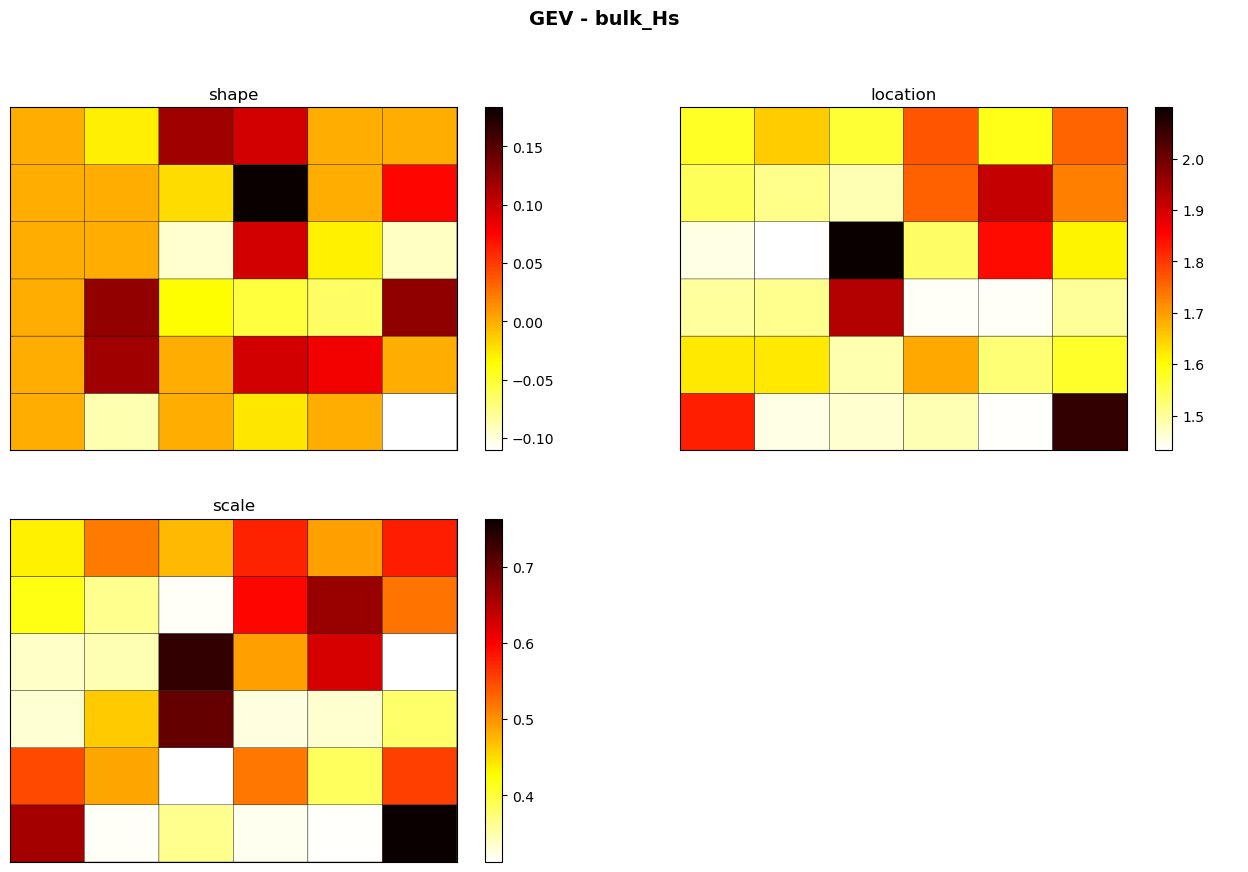

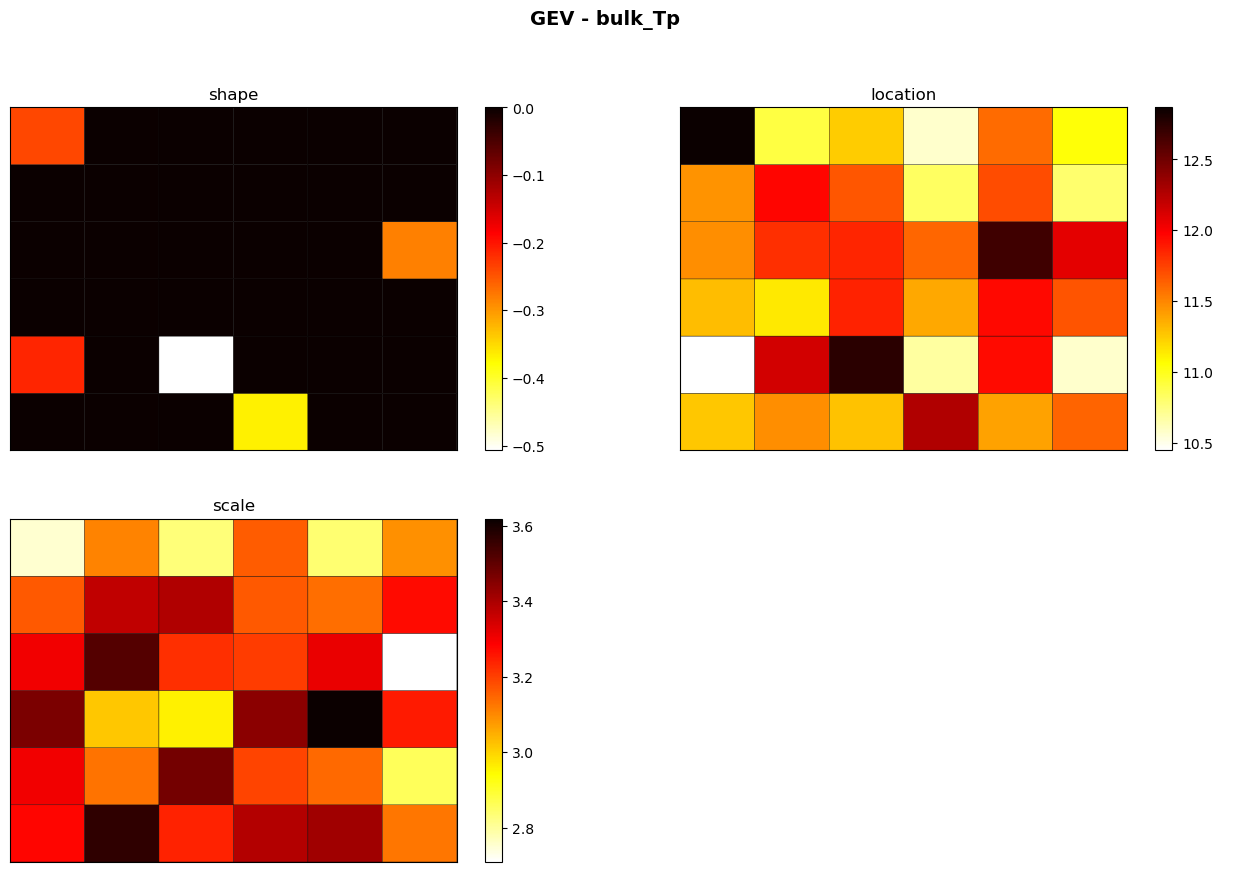

[<Figure size 1585.64x980 with 7 Axes>, <Figure size 1585.64x980 with 7 Axes>]

In [4]:
# Fit report figures

ce.Report_Fit(vns_GEV=["Hs", "Tp"], plot_chrom=False, plot_sigma=False)

In [5]:
# Load simulated DWTs

simulated_dwts = xr.open_dataset("outputs/dwt_alr/xds_output.nc")
simulated_dwts

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36891, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 295kB 1999-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 738kB ...
    ofbmus_sims  (time, n_sim) float32 738kB ...

In [6]:
simulated_waves = ce.Simulate_Waves(simulated_dwts.isel(n_sim=0), 1)
simulated_waves

C.E: Sim. Waves: 100%|██████████| 14465/14465 [00:49<00:00, 292.47it/s]


<xarray.Dataset> Size: 521kB
Dimensions:   (n_sim: 1, time: 14465)
Coordinates:
  * time      (time) datetime64[ns] 116kB 1999-01-01 1999-01-04 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    DWT       (n_sim, time) float32 58kB 5.0 16.0 5.0 2.0 ... 31.0 11.0 11.0
    bulk_Hs   (n_sim, time) float64 116kB 1.912 4.147 1.742 ... 2.441 1.481
    bulk_Tp   (n_sim, time) float64 116kB 11.51 15.2 10.03 ... 14.62 16.83 18.96
    bulk_Dir  (n_sim, time) float64 116kB 282.7 298.3 275.9 ... 272.9 240.8

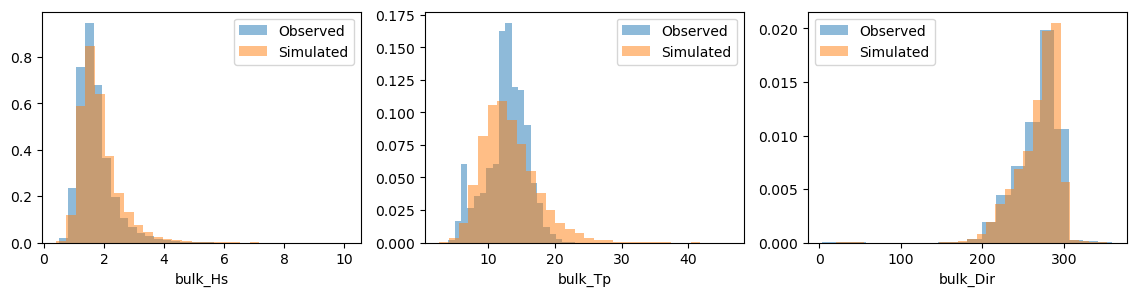

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 3))
waves["bulk_Hs"].plot.hist(ax=ax[0], label="Observed", alpha=0.5, density=True, bins=20)
simulated_waves["bulk_Hs"].plot.hist(
    ax=ax[0], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[0].legend()
waves["bulk_Tp"].plot.hist(ax=ax[1], label="Observed", alpha=0.5, density=True, bins=20)
simulated_waves["bulk_Tp"].plot.hist(
    ax=ax[1], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[1].legend()
waves["bulk_Dir"].plot.hist(
    ax=ax[2], label="Observed", alpha=0.5, density=True, bins=20
)
simulated_waves["bulk_Dir"].plot.hist(
    ax=ax[2], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[2].legend()